# Saliency Maps Experiment
This notebook sources from https://docs.openvino.ai/2023.2/notebooks/232-clip-language-saliency-map-with-output.html.




### Importing Necessary Packages and Setting Up Helper Functions

In [ ]:
# Install requirements
%pip install -q "openvino>=2023.1.0"
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu transformers torch gradio

In [ ]:
from pathlib import Path
from typing import Tuple, Union, Optional
from urllib.request import urlretrieve

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import tqdm
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

Install the CLIP model,using the `transformers` library and the official `openai/clip-vit-base-patch16` from OpenAI.

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-c8t8ng24
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-c8t8ng24
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)

In [ ]:
# generate crop coordinates and size
def get_random_crop_params(
    image_height: int, image_width: int, min_crop_size: int
) -> Tuple[int, int, int, int]:
    crop_size = np.random.randint(min_crop_size, min(image_height, image_width))
    x = np.random.randint(image_width - crop_size + 1)
    y = np.random.randint(image_height - crop_size + 1)
    return x, y, crop_size


def get_cropped_image(
    im_tensor: np.array, x: int, y: int, crop_size: int
) -> np.array:
    return im_tensor[:,
        y : y + crop_size,
        x : x + crop_size,
        ...
    ]

# update the saliency map with the calculated similarity
def update_saliency_map(
    saliency_map: np.array, similarity: float, x: int, y: int, crop_size: int
) -> None:
    saliency_map[
        y : y + crop_size,
        x : x + crop_size,
    ] += similarity


def cosine_similarity(
    one: Union[np.ndarray, torch.Tensor], other: Union[np.ndarray, torch.Tensor]
) -> Union[np.ndarray, torch.Tensor]:
    one = one.cpu().numpy()
    other = other.cpu().numpy()
    return one @ other.T / (np.linalg.norm(one) * np.linalg.norm(other))

### Clean image
Parameters to be defined:

- `n_iters` - number of times the procedure will be repeated. Larger is better, but will require more time to inference
- `min_crop_size` - minimum size of the crop window. A smaller size will increase the resolution of the saliency map but may require more iterations
- `query` - text that will be used to query the image
- `image` - the actual image that will be queried. You will download the image from a link.

In [ ]:
n_iters = 500
min_crop_size = 50

image = preprocess(Image.open("wolf.png"))  #[3, 224, 224] tensor
query = "Happy wolf"
text = clip.tokenize([query]).to(device)
x_dim, y_dim = image.shape[1:]

Given the `model` and `processor`, the actual inference is simple: transform the text and image into combined `inputs` and pass it to the model:

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image.unsqueeze(0).to(device)) #[1, 768] tensor
    text_features = model.encode_text(text) #[1, 768] tensor
clean_similarity = cosine_similarity(text_features, image_features).item()  # 1. Computing query and image similarity
saliency_map = np.zeros((y_dim, x_dim))

The model produces several outputs, but for your application, you are interested in `text_embeds` and `image_embeds`, which are the vectors for text and image, respectively. Now, you can calculate `initial_similarity` between the `query` and the `image`. You also initialize a saliency map.

In [ ]:
for _ in tqdm.notebook.tqdm(range(n_iters)):  # 6. Setting number of the procedure iterations
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(image, x, y, crop_size)  # 2. Getting a random crop of the image

    import torch.nn.functional as F

    new_height = 224
    new_width = 224

    im_crop = F.interpolate(im_crop.unsqueeze(0), size=(new_height, new_width), mode='bilinear', align_corners=False)

    with torch.no_grad():
      image_features = model.encode_image(im_crop.to(device))
      text_features = model.encode_text(text)

    similarity = cosine_similarity(text_features , image_features).item() - clean_similarity  # 4. Subtracting query and image similarity from crop and query similarity
    update_saliency_map(saliency_map, similarity, x, y, crop_size)  # 5. Updating the region on the saliency map

  0%|          | 0/500 [00:00<?, ?it/s]

To visualize the resulting saliency map, you can use `matplotlib`:

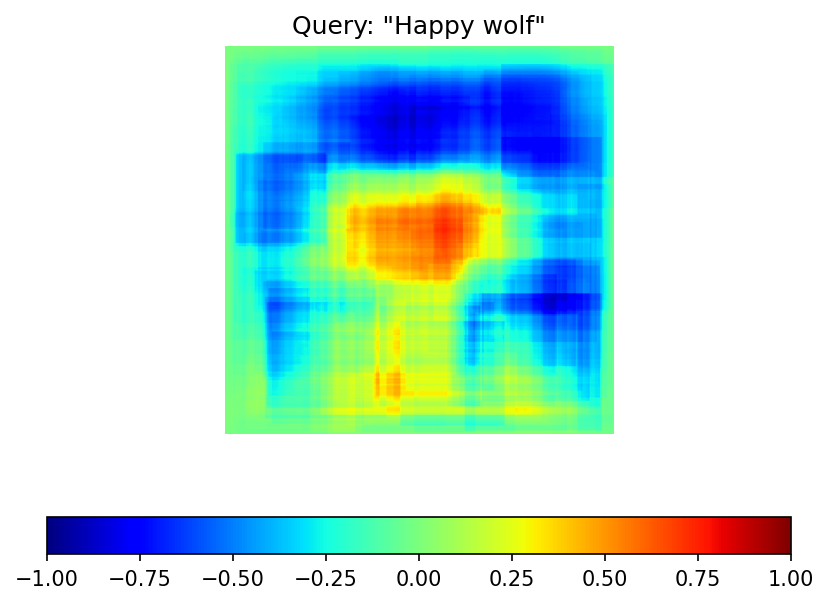

In [ ]:
plt.figure(dpi=150)
plt.imshow(saliency_map,
           norm=colors.TwoSlopeNorm(vmin=-1.,vcenter=0., vmax=1.),
           cmap='jet')
plt.colorbar(location="bottom")
plt.title(f'Query: \"{query}\"')
plt.axis("off")
plt.show()

The result map is not as smooth as in the example picture because of the lower number of iterations. However, the same red and blue areas are clearly visible.

Let us overlay the saliency map on the image:

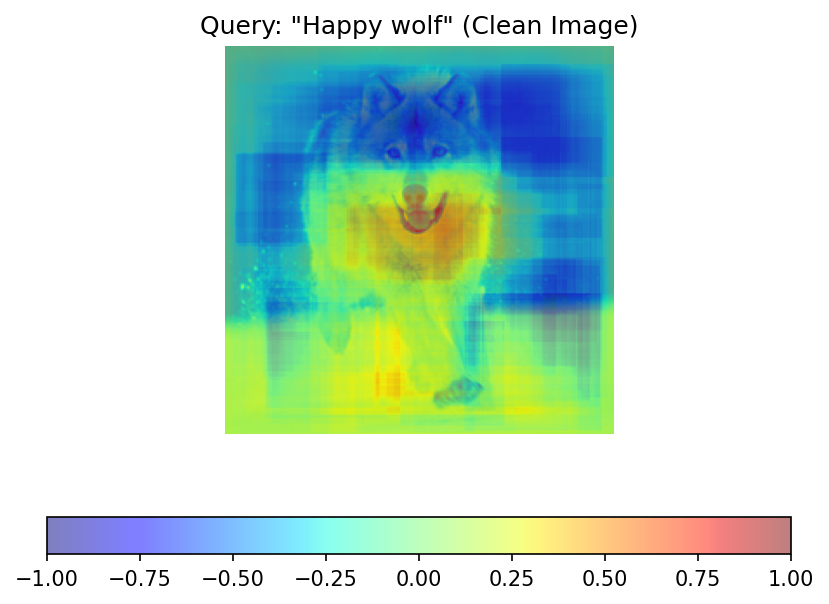

In [ ]:
def plot_saliency_map(image_tensor: np.ndarray, saliency_map: np.ndarray, query: Optional[str]) -> None:
    fig = plt.figure(dpi=150)
    plt.imshow(image_tensor)
    plt.imshow(
        saliency_map,
        norm=colors.TwoSlopeNorm(vmin=-1.,vcenter=0., vmax=1.),
        cmap="jet",
        alpha=0.5,  # make saliency map trasparent to see original picture
    )
    if query:
        plt.title(f'Query: "{query}" (Clean Image)')
    plt.axis("off")
    plt.colorbar(location="bottom")
    return fig

plot_saliency_map(np.array(image)[0,:,:], saliency_map, query);

### Adversarial Image

In [ ]:
n_iters = 500
min_crop_size = 50

image = preprocess(Image.open("wolf_adv.png")) #.unsqueeze(0).to(device)
query = "Happy wolf"
text = clip.tokenize([query]).to(device)

x_dim, y_dim = image.shape[1:]
with torch.no_grad():
    image_features = model.encode_image(image.unsqueeze(0).to(device))
    text_features = model.encode_text(text)
adv_similarity = cosine_similarity(text_features, image_features).item()  # 1. Computing query and image similarity

In [ ]:
# with torch.no_grad():
#     image_features = model.encode_image(image.unsqueeze(0).to(device))
#     text_features = model.encode_text(text)
# initial_similarity = cosine_similarity(text_features, image_features).item()  # 1. Computing query and image similarity
saliency_map = np.zeros((y_dim, x_dim))

for _ in tqdm.notebook.tqdm(range(n_iters)):  # 6. Setting number of the procedure iterations
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(image, x, y, crop_size)  # 2. Getting a random crop of the image

    import torch.nn.functional as F

    new_height = 224
    new_width = 224

    im_crop = F.interpolate(im_crop.unsqueeze(0), size=(new_height, new_width), mode='bilinear', align_corners=False)

    with torch.no_grad():
      image_features = model.encode_image(im_crop.to(device))
      text_features = model.encode_text(text)

    similarity = cosine_similarity(text_features , image_features).item() - clean_similarity # 4. Subtracting query and image similarity from crop and query similarity
    update_saliency_map(saliency_map, similarity, x, y, crop_size)  # 5. Updating the region on the saliency map

  0%|          | 0/500 [00:00<?, ?it/s]

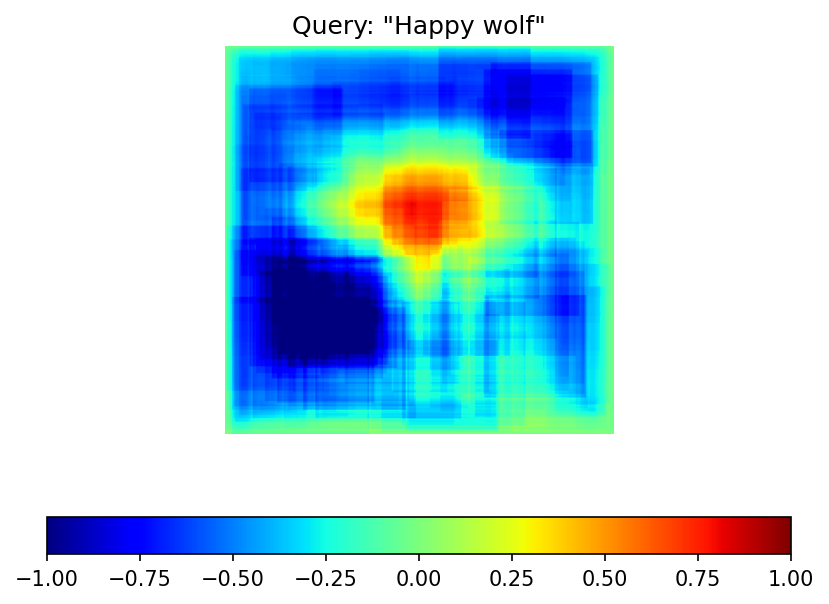

In [ ]:
plt.figure(dpi=150)
plt.imshow(saliency_map,
           norm=colors.TwoSlopeNorm(vmin=-1.,vcenter=0., vmax=1.),
           cmap='jet')
plt.colorbar(location="bottom")
plt.title(f'Query: \"{query}\"')
plt.axis("off")
plt.show()

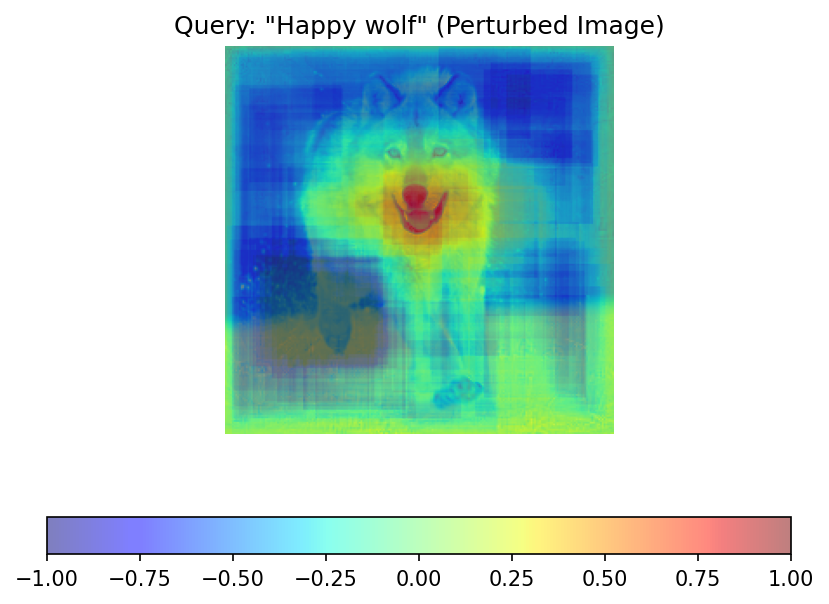

In [ ]:
def plot_saliency_map(image_tensor: np.ndarray, saliency_map: np.ndarray, query: Optional[str]) -> None:
    fig = plt.figure(dpi=150)
    plt.imshow(image_tensor)
    plt.imshow(
        saliency_map,
        norm=colors.TwoSlopeNorm(vmin=-1.,vcenter=0., vmax=1.),
        cmap="jet",
        alpha=0.5,  # make saliency map trasparent to see original picture
    )
    if query:
        plt.title(f'Query: "{query}" (Perturbed Image)')
    plt.axis("off")
    plt.colorbar(location="bottom")
    return fig



plot_saliency_map(np.array(image)[0,:,:]+10, saliency_map, query);